In [2]:
import os
from pathlib import Path

# ===== CONFIGURATION: choose thickness folder and specific .emd =====
DATASET_FOLDER = "30nm"            # Options: "60nm", "30nm", "120nm"
INPUT_FILENAME = "0924 20240626 Camera 220 kx 0001.emd"               # e.g., "1508 20250613 105 kx Ceta Camera" or full name with .emd
# ====================================================================

# Define base paths
BASE_DIR = Path(".")
DATA_DIR = BASE_DIR / "data" / DATASET_FOLDER
PROCESSED_DIR = BASE_DIR / "processed" / DATASET_FOLDER
ANNOTATIONS_DIR = BASE_DIR / "annotations" / DATASET_FOLDER

# Find candidate .emd files
emd_files = list(DATA_DIR.glob("*.emd"))
if not emd_files:
    raise FileNotFoundError(f"No .emd file found in {DATA_DIR}")

# Select specific file if requested
if INPUT_FILENAME:
    candidates = [f for f in emd_files if f.name == INPUT_FILENAME or f.stem == INPUT_FILENAME]
    if not candidates:
        available = "\n  - ".join(f.name for f in emd_files)
        raise FileNotFoundError(
            "Requested INPUT_FILENAME not found. Available files:\n  - " + available
        )
    INPUT_FILE = candidates[0]
else:
    if len(emd_files) > 1:
        available = "\n  - ".join(f.name for f in emd_files)
        raise FileExistsError(
            "Multiple .emd files found; set INPUT_FILENAME to choose one:\n  - " + available
        )
    INPUT_FILE = emd_files[0]

BASE_FILENAME = INPUT_FILE.stem  # Filename without extension

# Define output paths using the same base filename
OUTPUT_NPY = PROCESSED_DIR / f"{BASE_FILENAME}.npy"
OUTPUT_VIDEO = PROCESSED_DIR / f"{BASE_FILENAME}.mp4"

# Display configuration
print(f"{'='*60}")
print("Dataset Configuration")
print(f"{'='*60}")
print(f"Folder:       {DATASET_FOLDER}")
print(f"Input file:   {INPUT_FILE.name}")
print(f"Base name:    {BASE_FILENAME}")
print(f"{'='*60}")
print(f"Output .npy:  {OUTPUT_NPY}")
print(f"Output video: {OUTPUT_VIDEO}")
print(f"{'='*60}")

Dataset Configuration
Folder:       30nm
Input file:   0924 20240626 Camera 220 kx 0001.emd
Base name:    0924 20240626 Camera 220 kx 0001
Output .npy:  processed\30nm\0924 20240626 Camera 220 kx 0001.npy
Output video: processed\30nm\0924 20240626 Camera 220 kx 0001.mp4


# Noise Removal and Frame Registration Pipeline

This notebook processes in-situ tensile test data by:
1. Removing low-quality frames based on sharpness and edge content
2. Registering frames to correct drift using phase cross-correlation
3. Saving processed data for annotation and training

In [3]:
import hyperspy.api as hs
import numpy as np
import matplotlib.pyplot as plt
from skimage.registration import phase_cross_correlation
from scipy.ndimage import shift as scipy_shift

# Load the EMD file using the configured path
print(f"Loading: {INPUT_FILE}")
s = hs.load(str(INPUT_FILE))

# Check the signal structure
print(s)
print(f"Signal shape: {s.data.shape}")
print(f"Signal axes: {s.axes_manager}")

Loading: data\30nm\0924 20240626 Camera 220 kx 0001.emd
<Signal2D, title: Ceta, dimensions: (835|1024, 1024)>
Signal shape: (835, 1024, 1024)
Signal axes: <Axes manager, axes: (835|1024, 1024)>
            Name |   size |  index |  offset |   scale |  units 
================ | ====== | ====== | ======= | ======= | ====== 
            Time |    835 |      0 |       0 |    0.64 |      s 
---------------- | ------ | ------ | ------- | ------- | ------ 
               x |   1024 |      0 |     -92 |    0.18 |     nm 
               y |   1024 |      0 |     -92 |    0.18 |     nm 


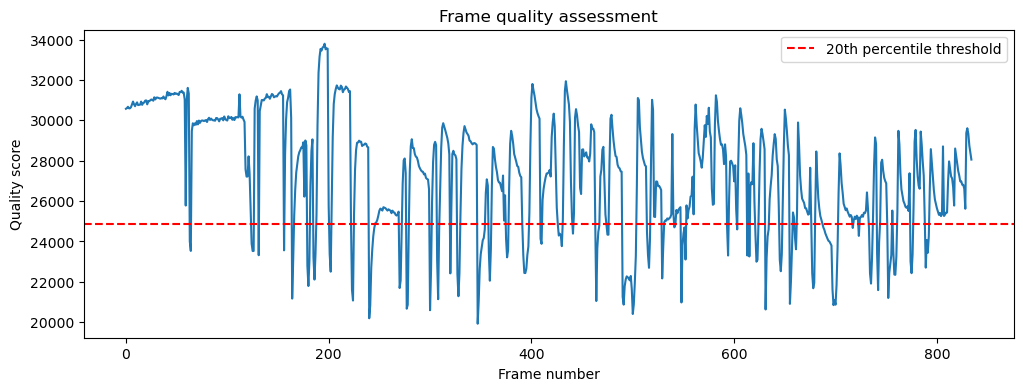

Keeping 668/835 frames


In [4]:
def assess_frame_quality(signal):
    """
    Calculate quality metrics for each frame in the stack
    Returns array of quality scores
    """
    n_frames = signal.data.shape[0]
    quality_scores = np.zeros(n_frames)
    
    for i in range(n_frames):
        frame = signal.inav[i].data
        
        # Method 1: Variance of Laplacian (sharpness)
        from scipy.ndimage import laplace
        laplacian = laplace(frame)
        sharpness = np.var(laplacian)
        
        # Method 2: Standard deviation (contrast)
        contrast = np.std(frame)
        
        # Method 3: Edge content
        from scipy.ndimage import sobel
        edges_x = sobel(frame, axis=0)
        edges_y = sobel(frame, axis=1)
        edge_magnitude = np.sqrt(edges_x**2 + edges_y**2)
        edge_content = np.mean(edge_magnitude)
        
        # Combined quality score
        quality_scores[i] = sharpness * edge_content
    
    return quality_scores

# Assess quality
quality = assess_frame_quality(s)

# Visualize quality over time
plt.figure(figsize=(12, 4))
plt.plot(quality)
plt.xlabel('Frame number')
plt.ylabel('Quality score')
plt.title('Frame quality assessment')
plt.axhline(np.percentile(quality, 20), color='r', linestyle='--', 
            label='20th percentile threshold')
plt.legend()
plt.show()

# Identify good frames
threshold = np.percentile(quality, 20)  # Remove bottom 20%
good_frame_indices = np.where(quality > threshold)[0]
print(f"Keeping {len(good_frame_indices)}/{len(quality)} frames")

In [5]:
def remove_bad_frames(signal, good_indices):
    """
    Create new signal with only good frames
    """
    # Extract good frames
    good_data = signal.data[good_indices]
    
    # Create new signal
    s_clean = hs.signals.Signal2D(good_data)
    
    # Copy metadata and calibration
    s_clean.axes_manager[0].name = signal.axes_manager[0].name
    s_clean.axes_manager[0].units = signal.axes_manager[0].units
    s_clean.axes_manager[1].scale = signal.axes_manager[1].scale
    s_clean.axes_manager[1].units = signal.axes_manager[1].units
    s_clean.axes_manager[2].scale = signal.axes_manager[2].scale
    s_clean.axes_manager[2].units = signal.axes_manager[2].units
    
    return s_clean

# Remove bad frames
s_clean = remove_bad_frames(s, good_frame_indices)

In [6]:
def select_roi_interactive(signal, frame_idx=0):
    """
    Interactive ROI selector for registration feature

    Parameters:
    -----------
    signal : hyperspy Signal2D
        Input signal stack
    frame_idx : int
        Frame to display for ROI selection

    Returns:
    --------
    roi_coords : tuple
        (y_start, y_end, x_start, x_end) coordinates
    """
    import ipywidgets as widgets
    from IPython.display import display

    # Store ROI coordinates
    roi = {'coords': None}

    def update_roi(y_start, y_end, x_start, x_end):
        roi['coords'] = (y_start, y_end, x_start, x_end)

        fig, ax = plt.subplots(1, 1, figsize=(10, 10))
        frame = signal.inav[frame_idx].data
        ax.imshow(frame, cmap='gray')

        # Draw rectangle
        from matplotlib.patches import Rectangle
        rect = Rectangle((x_start, y_start), x_end-x_start, y_end-y_start,
                         linewidth=2, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
        ax.set_title(f'Selected ROI: y=[{y_start}:{y_end}], x=[{x_start}:{x_end}]')
        ax.axis('off')
        plt.tight_layout()
        plt.show()

    h, w = signal.data.shape[1], signal.data.shape[2]

    # Default to top middle region for crack
    default_y_start = 0
    default_y_end = h // 3  # Top third
    default_x_start = w // 4  # Middle half
    default_x_end = 3 * w // 4

    style = {'description_width': '100px'}

    y_start_slider = widgets.IntSlider(min=0, max=h-50, value=default_y_start,
                                       description='Y Start:', style=style)
    y_end_slider = widgets.IntSlider(min=50, max=h, value=default_y_end,
                                     description='Y End:', style=style)
    x_start_slider = widgets.IntSlider(min=0, max=w-50, value=default_x_start,
                                       description='X Start:', style=style)
    x_end_slider = widgets.IntSlider(min=50, max=w, value=default_x_end,
                                     description='X End:', style=style)

    widgets.interact(update_roi,
                    y_start=y_start_slider,
                    y_end=y_end_slider,
                    x_start=x_start_slider,
                    x_end=x_end_slider)

    return roi

def register_signal_stack_sequential(signal, roi_coords=None, upsample_factor=10,
                                     reference_frame=0, max_shift_px=200):
    """
    Register frames using ROI-based registration to a reference frame

    This approach prevents drift accumulation by:
    1. Each frame is registered to a REFERENCE frame (not the previous frame)
    2. Registration uses only a ROI containing stable features (e.g., crack)
    3. This prevents error accumulation that occurs in sequential registration

    Parameters:
    -----------
    signal : hyperspy Signal2D
        Input signal stack
    roi_coords : tuple or None
        (y_start, y_end, x_start, x_end) for registration ROI
        If None, uses full frame
    upsample_factor : int
        Subpixel precision (higher = more precise but slower)
    reference_frame : int
        Frame to use as reference (default: 0)
    max_shift_px : float
        Maximum allowed shift from reference (outlier detection)

    Returns:
    --------
    registered_signal : hyperspy Signal2D
        Registered signal stack
    shifts : ndarray
        Array of (y, x) shifts for each frame relative to reference
    """
    from tqdm.notebook import tqdm

    n_frames = signal.data.shape[0]
    registered_data = np.zeros(signal.data.shape, dtype=np.float32)
    shifts = np.zeros((n_frames, 2), dtype=np.float32)

    # Get reference frame
    reference = signal.inav[reference_frame].data.astype(np.float32, copy=False)
    registered_data[reference_frame] = reference

    # Extract ROI helper
    def get_roi(frame):
        if roi_coords is not None:
            y0, y1, x0, x1 = roi_coords
            return frame[y0:y1, x0:x1]
        return frame

    print(f"Starting ROI-based registration to reference frame {reference_frame}...")
    if roi_coords is not None:
        y0, y1, x0, x1 = roi_coords
        print(f"Using ROI: y=[{y0}:{y1}], x=[{x0}:{x1}]")
    else:
        print("Using full frame")

    # Get reference ROI once
    reference_roi = get_roi(reference)

    # Register each frame to the reference
    for i in tqdm(range(n_frames),
                  desc="Registering frames",
                  unit="frame",
                  colour='green'):

        if i == reference_frame:
            continue  # Skip reference frame

        # Get current frame
        curr_frame = signal.inav[i].data.astype(np.float32, copy=False)
        curr_roi = get_roi(curr_frame)

        # Calculate shift relative to REFERENCE frame (not previous frame)
        shift, error, diffphase = phase_cross_correlation(
            reference_roi,
            curr_roi,
            upsample_factor=upsample_factor
        )

        # Outlier detection: flag large jumps
        shift_magnitude = np.sqrt(shift[0]**2 + shift[1]**2)
        if shift_magnitude > max_shift_px:
            print(f"\nWarning: Frame {i} has large shift {shift} (mag={shift_magnitude:.1f}px)")
            print(f"  This frame may be poor quality - keeping original shift")

        shifts[i] = shift

        # Apply shift to current frame
        registered_data[i] = scipy_shift(curr_frame, shift,
                                         mode='constant', cval=0)

    # Create registered signal
    s_registered = hs.signals.Signal2D(registered_data)

    # Copy metadata
    s_registered.axes_manager[0].name = signal.axes_manager[0].name
    s_registered.axes_manager[0].units = signal.axes_manager[0].units
    s_registered.axes_manager[1].scale = signal.axes_manager[1].scale
    s_registered.axes_manager[1].units = signal.axes_manager[1].units
    s_registered.axes_manager[2].scale = signal.axes_manager[2].scale
    s_registered.axes_manager[2].units = signal.axes_manager[2].units

    print(f"\nRegistration complete! Processed {n_frames} frames.")
    print(f"Maximum shift from reference: ({np.max(np.abs(shifts[:,0])):.2f}, "
          f"{np.max(np.abs(shifts[:,1])):.2f}) pixels")
    print(f"Mean shift magnitude: {np.mean(np.sqrt(shifts[:,0]**2 + shifts[:,1]**2)):.2f} pixels")

    return s_registered, shifts

In [ ]:
# Interactive ROI selection and sequential frame registration
roi = select_roi_interactive(s_clean, frame_idx=0)

interactive(children=(IntSlider(value=0, description='Y Start:', max=974, style=SliderStyle(description_width=…

In [8]:
# Wait for user to select ROI, then register
if roi['coords'] is not None:
    s_registered, shifts = register_signal_stack_sequential(
        s_clean, 
        roi_coords=roi['coords'],
        upsample_factor=10,
        reference_frame=0,
        max_shift_px=200
    )
    print(f"\n✓ ROI-based registration complete")
else:
    print("No ROI selected. Please run the cell again and select an ROI.")

Starting ROI-based registration to reference frame 0...
Using ROI: y=[375:798], x=[528:908]


Registering frames:   0%|          | 0/668 [00:00<?, ?frame/s]


Registration complete! Processed 668 frames.
Maximum shift from reference: (15.10, 2.70) pixels
Mean shift magnitude: 0.08 pixels

✓ ROI-based registration complete


✓ Truncated to 668 frames (0-667)

Shift statistics (reference-based):
  Median: 0.00 px, MAD: 0.00 px, Threshold: 3.00 px
Frame-to-frame jump statistics:
  Median: 0.00 px, MAD: 0.00 px, Threshold: 3.00 px

Frames removed (total): 10 / 668 (1.5%)
  Due to large global shift: [4, 5, 7, 8, 11, 17]
  Due to frame-to-frame jumps: [6, 7, 9, 11, 12, 17, 18]


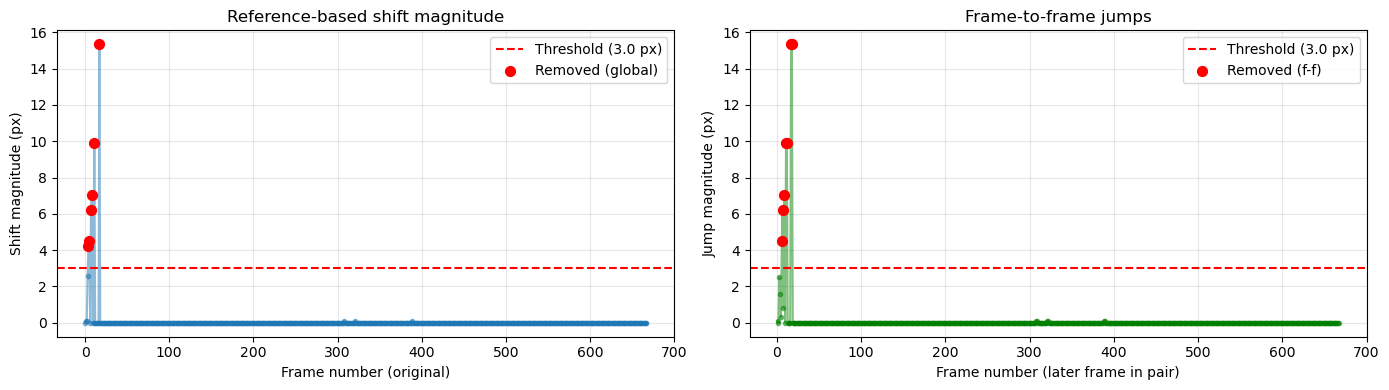


✓ Final dataset: 658 frames after cleanup


In [9]:
# Clean up registered data: remove frames with large jumps

max_frame = 667
s_registered_trimmed = hs.signals.Signal2D(s_registered.data[:max_frame+1])
shifts_trimmed = shifts[:max_frame+1]

# Copy metadata
s_registered_trimmed.axes_manager[0].name = s_registered.axes_manager[0].name
s_registered_trimmed.axes_manager[0].units = s_registered.axes_manager[0].units
s_registered_trimmed.axes_manager[1].scale = s_registered.axes_manager[1].scale
s_registered_trimmed.axes_manager[1].units = s_registered.axes_manager[1].units
s_registered_trimmed.axes_manager[2].scale = s_registered.axes_manager[2].scale
s_registered_trimmed.axes_manager[2].units = s_registered.axes_manager[2].units

print(f"✓ Truncated to {len(s_registered_trimmed.data)} frames (0-{max_frame})")

# Step 2a: Outliers vs reference (global shift magnitude)
shift_magnitude = np.sqrt(shifts_trimmed[:, 0]**2 + shifts_trimmed[:, 1]**2)
median_shift = np.median(shift_magnitude)
mad_shift = np.median(np.abs(shift_magnitude - median_shift))
# Robust threshold (3×MAD); fallback if MAD≈0
threshold_shift = median_shift + (3 * mad_shift if mad_shift > 1e-6 else 3.0)

# Step 2b: Frame-to-frame jump magnitude (temporal discontinuities)
# Compute per-step delta of the shift vector relative to the reference
ff_delta = np.diff(shifts_trimmed, axis=0)
ff_jump_mag = np.sqrt(ff_delta[:, 0]**2 + ff_delta[:, 1]**2)
median_ff = np.median(ff_jump_mag)
mad_ff = np.median(np.abs(ff_jump_mag - median_ff))
ff_threshold = median_ff + (3 * mad_ff if mad_ff > 1e-6 else 3.0)

# Build mask of good frames (start with all True)
good_mask = np.ones(len(s_registered_trimmed.data), dtype=bool)

# Remove frames with large global shift magnitude
bad_global = shift_magnitude > threshold_shift
if np.any(bad_global):
    good_mask[bad_global] = False

# Remove frames that jump relative to their immediate predecessor
# For each large jump between i-1 -> i, drop the later frame i
bad_ff_indices = np.where(ff_jump_mag > ff_threshold)[0] + 1  # shift indexes by +1
if len(bad_ff_indices) > 0:
    good_mask[bad_ff_indices] = False

n_removed = int(np.sum(~good_mask))

print("\nShift statistics (reference-based):")
print(f"  Median: {median_shift:.2f} px, MAD: {mad_shift:.2f} px, Threshold: {threshold_shift:.2f} px")
print("Frame-to-frame jump statistics:")
print(f"  Median: {median_ff:.2f} px, MAD: {mad_ff:.2f} px, Threshold: {ff_threshold:.2f} px")
print(f"\nFrames removed (total): {n_removed} / {len(good_mask)} ({n_removed/len(good_mask)*100:.1f}%)")
if np.any(bad_global):
    print(f"  Due to large global shift: {np.where(bad_global)[0].tolist()}")
if len(bad_ff_indices) > 0:
    print(f"  Due to frame-to-frame jumps: {bad_ff_indices.tolist()}")

# Create final cleaned signal
s_registered = hs.signals.Signal2D(s_registered_trimmed.data[good_mask])

# Copy metadata
s_registered.axes_manager[0].name = s_registered_trimmed.axes_manager[0].name
s_registered.axes_manager[0].units = s_registered_trimmed.axes_manager[0].units
s_registered.axes_manager[1].scale = s_registered_trimmed.axes_manager[1].scale
s_registered.axes_manager[1].units = s_registered_trimmed.axes_manager[1].units
s_registered.axes_manager[2].scale = s_registered_trimmed.axes_manager[2].scale
s_registered.axes_manager[2].units = s_registered_trimmed.axes_manager[2].units

# Visualize shifts and jumps before/after
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

# Panel 1: global shift magnitude vs reference
axes[0].plot(shift_magnitude, 'o-', alpha=0.5, markersize=3)
axes[0].axhline(threshold_shift, color='r', linestyle='--', label=f'Threshold ({threshold_shift:.1f} px)')
axes[0].scatter(np.where(bad_global)[0], shift_magnitude[bad_global], color='r', s=50, zorder=5, label='Removed (global)')
axes[0].set_xlabel('Frame number (original)')
axes[0].set_ylabel('Shift magnitude (px)')
axes[0].set_title('Reference-based shift magnitude')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Panel 2: frame-to-frame jump magnitude
axes[1].plot(np.arange(1, len(ff_jump_mag)+1), ff_jump_mag, 'o-', alpha=0.5, markersize=3, color='green')
axes[1].axhline(ff_threshold, color='r', linestyle='--', label=f'Threshold ({ff_threshold:.1f} px)')
axes[1].scatter(bad_ff_indices, ff_jump_mag[bad_ff_indices-1], color='r', s=50, zorder=5, label='Removed (f-f)')
axes[1].set_xlabel('Frame number (later frame in pair)')
axes[1].set_ylabel('Jump magnitude (px)')
axes[1].set_title('Frame-to-frame jumps')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n✓ Final dataset: {len(s_registered.data)} frames after cleanup")

In [ ]:
# def register_signal_stack(signal, reference_frame=0, upsample_factor=10):
#     """
#     Register all frames to a reference frame using phase cross-correlation
    
#     Parameters:
#     -----------
#     signal : hyperspy Signal2D
#         Input signal stack
#     reference_frame : int
#         Index of frame to use as reference (default: 0)
#     upsample_factor : int
#         Subpixel precision (higher = more precise but slower)
    
#     Returns:
#     --------
#     registered_signal : hyperspy Signal2D
#         Registered signal stack
#     shifts : ndarray
#         Array of (y, x) shifts for each frame
#     """
#     from tqdm.notebook import tqdm  # For Jupyter notebooks
#     # from tqdm import tqdm  # For terminal/scripts
    
#     n_frames = signal.data.shape[0]
#     reference = signal.inav[reference_frame].data
    
#     registered_data = np.zeros_like(signal.data)
#     shifts = np.zeros((n_frames, 2))
    
#     # Use tqdm for progress bar with more details
#     for i in tqdm(range(n_frames), 
#                   desc="Registering frames", 
#                   unit="frame",
#                   colour='green',
#                   leave=True):
        
#         frame = signal.inav[i].data
        
#         # Calculate shift using phase cross-correlation
#         shift, error, diffphase = phase_cross_correlation(
#             reference, 
#             frame, 
#             upsample_factor=upsample_factor
#         )
        
#         shifts[i] = shift
        
#         # Apply shift
#         registered_data[i] = scipy_shift(frame, shift, mode='constant', cval=0)
    
#     # Create registered signal
#     s_registered = hs.signals.Signal2D(registered_data)
    
#     # Copy metadata
#     s_registered.axes_manager[0].name = signal.axes_manager[0].name
#     s_registered.axes_manager[0].units = signal.axes_manager[0].units
#     s_registered.axes_manager[1].scale = signal.axes_manager[1].scale
#     s_registered.axes_manager[1].units = signal.axes_manager[1].units
#     s_registered.axes_manager[2].scale = signal.axes_manager[2].scale
#     s_registered.axes_manager[2].units = signal.axes_manager[2].units
    
#     print(f"\nRegistration complete! Processed {n_frames} frames.")
#     print(f"Maximum shift: ({np.max(np.abs(shifts[:,0])):.2f}, {np.max(np.abs(shifts[:,1])):.2f}) pixels")
    
#     return s_registered, shifts

# # Register cleaned signal
# s_registered, shifts = register_signal_stack(s_clean, reference_frame=0, upsample_factor=10)

Registering frames:   0%|          | 0/625 [00:00<?, ?frame/s]


Registration complete! Processed 625 frames.
Maximum shift: (80.50, 57.70) pixels


In [ ]:
def interactive_quality_check(signal, quality_scores):
    """
    Interactive tool to check quality assessment
    """
    import ipywidgets as widgets
    from IPython.display import display
    
    def show_frame(frame_idx):
        fig, axes = plt.subplots(1, 2, figsize=(14, 5))
        
        # Show frame
        axes[0].imshow(signal.inav[frame_idx].data, cmap='gray')
        axes[0].set_title(f'Frame {frame_idx}')
        axes[0].axis('off')
        
        # Show quality scores
        axes[1].plot(quality_scores)
        axes[1].axvline(frame_idx, color='r', linestyle='--')
        axes[1].scatter([frame_idx], [quality_scores[frame_idx]], 
                       color='r', s=100, zorder=5)
        axes[1].set_xlabel('Frame number')
        axes[1].set_ylabel('Quality score')
        axes[1].set_title(f'Quality: {quality_scores[frame_idx]:.2f}')
        
        plt.tight_layout()
        plt.show()
    
    slider = widgets.IntSlider(
        min=0, 
        max=len(signal.data)-1, 
        step=1, 
        value=0,
        description='Frame:'
    )
    
    widgets.interact(show_frame, frame_idx=slider)

# Use in Jupyter notebook
interactive_quality_check(s_registered, quality)

interactive(children=(IntSlider(value=0, description='Frame:', max=657), Output()), _dom_classes=('widget-inte…

In [11]:
import cv2
from tqdm.notebook import tqdm

def save_signal_as_video(signal, filename='registered_frames.mp4', fps=25, codec='mp4v', 
                         frame_skip=1, max_frames=None, chunk_size=100, 
                         vmin_percentile=1, vmax_percentile=99):
    """
    Save hyperspy signal stack as video file with memory-efficient processing
    
    Parameters:
    -----------
    signal : hyperspy Signal2D
        Input signal stack
    filename : str
        Output filename (with .mp4 or .avi extension)
    fps : int
        Frames per second for output video
    codec : str
        Video codec ('mp4v' for mp4, 'XVID' for avi)
    frame_skip : int
        Use every Nth frame (1=all frames, 2=every other frame, etc.)
        Useful for large datasets to reduce output size
    max_frames : int or None
        Maximum number of frames to include (after skipping). None = all frames
    chunk_size : int
        Number of frames to normalize at once (reduces memory usage)
    vmin_percentile : float
        Lower percentile for contrast stretching (default: 1)
    vmax_percentile : float
        Upper percentile for contrast stretching (default: 99)
    """
    n_frames = signal.data.shape[0]
    height, width = signal.data.shape[1], signal.data.shape[2]
    
    # Calculate which frames to include
    frame_indices = np.arange(0, n_frames, frame_skip)
    if max_frames is not None:
        frame_indices = frame_indices[:max_frames]
    
    total_output_frames = len(frame_indices)
    
    print(f"Input: {n_frames} frames")
    print(f"Output: {total_output_frames} frames (skip={frame_skip}, max={max_frames})")
    print(f"Resolution: {width}x{height}, FPS: {fps}")
    print(f"Estimated video duration: {total_output_frames/fps:.1f} seconds")
    
    # Calculate percentile-based intensity range for better contrast (chunked)
    print(f"\nCalculating intensity range (percentiles: {vmin_percentile}-{vmax_percentile})...")
    all_samples = []
    sample_size = min(50000, width * height * 5)  # Sample ~5 frames worth of pixels
    
    for i in tqdm(range(0, len(frame_indices), max(1, len(frame_indices)//10)), 
                  desc="Sampling", unit="frame"):
        idx = frame_indices[i]
        frame_sample = signal.data[idx].flatten()
        # Take random sample from this frame
        sample_idx = np.random.choice(len(frame_sample), 
                                     min(len(frame_sample), sample_size//10), 
                                     replace=False)
        all_samples.extend(frame_sample[sample_idx])
    
    # Calculate percentiles from samples
    data_min = np.percentile(all_samples, vmin_percentile)
    data_max = np.percentile(all_samples, vmax_percentile)
    
    print(f"Intensity range: [{data_min:.2f}, {data_max:.2f}]")
    print(f"  (This clips ~{vmin_percentile}% darkest and ~{100-vmax_percentile}% brightest pixels)")
    
    # Define codec and create VideoWriter
    fourcc = cv2.VideoWriter_fourcc(*codec)
    out = cv2.VideoWriter(filename, fourcc, fps, (width, height), isColor=False)
    
    if not out.isOpened():
        print(f"Error: Could not open video writer for {filename}")
        print("Try: codec='XVID' and filename='output.avi' as alternative")
        return False
    
    # Write frames in chunks (memory efficient)
    print("\nWriting video...")
    for i in tqdm(range(0, len(frame_indices), chunk_size), desc="Encoding", unit="chunk"):
        chunk_idx = frame_indices[i:i+chunk_size]
        
        # Normalize chunk with percentile clipping
        chunk_data = signal.data[chunk_idx].copy()
        # Clip values outside the range
        chunk_data = np.clip(chunk_data, data_min, data_max)
        # Normalize to 0-255
        chunk_normalized = ((chunk_data - data_min) / (data_max - data_min) * 255).astype(np.uint8)
        
        # Write each frame in chunk
        for frame in chunk_normalized:
            out.write(frame)
    
    out.release()
    print(f"\n✓ Video saved: {filename}")
    print(f"  Frames: {total_output_frames}, Resolution: {width}x{height}, FPS: {fps}")
    
    return True

# Save video using the configured output path
save_signal_as_video(s_registered, filename=str(OUTPUT_VIDEO), fps=25, codec='mp4v')

# Alternative: Adjust contrast range if needed (e.g., for very noisy data)
# save_signal_as_video(s_registered, filename=str(OUTPUT_VIDEO), fps=25, 
#                      codec='mp4v', vmin_percentile=2, vmax_percentile=98)

Input: 658 frames
Output: 658 frames (skip=1, max=None)
Resolution: 1024x1024, FPS: 25
Estimated video duration: 26.3 seconds

Calculating intensity range (percentiles: 1-99)...


Sampling:   0%|          | 0/11 [00:00<?, ?frame/s]

Intensity range: [9.00, 235.00]
  (This clips ~1% darkest and ~1% brightest pixels)

Writing video...


Encoding:   0%|          | 0/7 [00:00<?, ?chunk/s]


✓ Video saved: processed\30nm\0924 20240626 Camera 220 kx 0001.mp4
  Frames: 658, Resolution: 1024x1024, FPS: 25


True

In [12]:
# Save the processed data using the configured path
print(f"Saving registered frames...")
np.save(str(OUTPUT_NPY), s_registered.data)
print(f"✓ Saved to: {OUTPUT_NPY}")
print(f"  Shape: {s_registered.data.shape}")
print(f"  File size: {OUTPUT_NPY.stat().st_size / (1024**2):.1f} MB")

Saving registered frames...
✓ Saved to: processed\30nm\0924 20240626 Camera 220 kx 0001.npy
  Shape: (658, 1024, 1024)
  File size: 2632.0 MB


To measure another video that has a different magnification and merge it with the above file.

In [1]:
import numpy as np
from pathlib import Path
from skimage.transform import resize

# ---- configure paths and crop margins (in pixels) ----
SOURCE_51K = Path("processed/120nm/20240715 1934 Camera 51000 x.npy")   # update
REF_66K    = Path("processed/120nm/20240715 2022 Camera 66000 x.npy")  # current 66K stack
OUT_51K_RS = Path("processed/120nm/20240715 1934 Camera 51000 x_rescaled.npy")            # output path
CROP_BOTTOM = 80   # pixels to remove from bottom (scale bar area)
CROP_RIGHT  = 120  # pixels to remove from right  (scale bar area)

# ---- load reference shape and source ----
ref = np.load(REF_66K, mmap_mode="r")
target_h, target_w = ref.shape[1], ref.shape[2]

src = np.load(SOURCE_51K, mmap_mode="r")
h, w = src.shape[1], src.shape[2]

# ---- crop bottom-right ----
cropped = src[:, 0:h-CROP_BOTTOM, 0:w-CROP_RIGHT]

# ---- resize each frame to match 66K pixel dimensions ----
rescaled = np.empty((cropped.shape[0], target_h, target_w), dtype=src.dtype)
for i in range(cropped.shape[0]):
    rescaled[i] = resize(
        cropped[i],
        (target_h, target_w),
        order=1,               # bilinear
        mode="reflect",
        anti_aliasing=True,
        preserve_range=True,
    ).astype(src.dtype)

# ---- save ----
np.save(OUT_51K_RS, rescaled)
print(f"Saved: {OUT_51K_RS} with shape {rescaled.shape}")
# ...existing code...

Saved: processed\120nm\20240715 1934 Camera 51000 x_rescaled.npy with shape (385, 1024, 1024)


In [5]:
import cv2
import hyperspy.api as hs
from tqdm.notebook import tqdm


def save_signal_as_video(signal, filename='registered_frames.mp4', fps=25, codec='mp4v',
                         frame_skip=1, max_frames=None, chunk_size=100,
                         vmin_percentile=1, vmax_percentile=99):
    """
    Save hyperspy signal stack as video file with memory-efficient processing

    Parameters:
    -----------
    signal : hyperspy Signal2D
        Input signal stack
    filename : str
        Output filename (with .mp4 or .avi extension)
    fps : int
        Frames per second for output video
    codec : str
        Video codec ('mp4v' for mp4, 'XVID' for avi)
    frame_skip : int
        Use every Nth frame (1=all frames, 2=every other frame, etc.)
        Useful for large datasets to reduce output size
    max_frames : int or None
        Maximum number of frames to include (after skipping). None = all frames
    chunk_size : int
        Number of frames to normalize at once (reduces memory usage)
    vmin_percentile : float
        Lower percentile for contrast stretching (default: 1)
    vmax_percentile : float
        Upper percentile for contrast stretching (default: 99)
    """
    n_frames = signal.data.shape[0]
    height, width = signal.data.shape[1], signal.data.shape[2]

    # Calculate which frames to include
    frame_indices = np.arange(0, n_frames, frame_skip)
    if max_frames is not None:
        frame_indices = frame_indices[:max_frames]

    total_output_frames = len(frame_indices)

    print(f"Input: {n_frames} frames")
    print(f"Output: {total_output_frames} frames (skip={frame_skip}, max={max_frames})")
    print(f"Resolution: {width}x{height}, FPS: {fps}")
    print(f"Estimated video duration: {total_output_frames/fps:.1f} seconds")

    # Calculate percentile-based intensity range for better contrast (chunked)
    print(f"\nCalculating intensity range (percentiles: {vmin_percentile}-{vmax_percentile})...")
    all_samples = []
    sample_size = min(50000, width * height * 5)  # Sample ~5 frames worth of pixels

    for i in tqdm(range(0, len(frame_indices), max(1, len(frame_indices)//10)),
                  desc="Sampling", unit="frame"):
        idx = frame_indices[i]
        frame_sample = signal.data[idx].flatten()
        # Take random sample from this frame
        sample_idx = np.random.choice(len(frame_sample),
                                     min(len(frame_sample), sample_size//10),
                                     replace=False)
        all_samples.extend(frame_sample[sample_idx])

    # Calculate percentiles from samples
    data_min = np.percentile(all_samples, vmin_percentile)
    data_max = np.percentile(all_samples, vmax_percentile)

    print(f"Intensity range: [{data_min:.2f}, {data_max:.2f}]")
    print(f"  (This clips ~{vmin_percentile}% darkest and ~{100-vmax_percentile}% brightest pixels)")

    # Define codec and create VideoWriter
    fourcc = cv2.VideoWriter_fourcc(*codec)
    out = cv2.VideoWriter(filename, fourcc, fps, (width, height), isColor=False)

    if not out.isOpened():
        print(f"Error: Could not open video writer for {filename}")
        print("Try: codec='XVID' and filename='output.avi' as alternative")
        return False

    # Write frames in chunks (memory efficient)
    print("\nWriting video...")
    for i in tqdm(range(0, len(frame_indices), chunk_size), desc="Encoding", unit="chunk"):
        chunk_idx = frame_indices[i:i+chunk_size]

        # Normalize chunk with percentile clipping
        chunk_data = signal.data[chunk_idx].copy()
        # Clip values outside the range
        chunk_data = np.clip(chunk_data, data_min, data_max)
        # Normalize to 0-255
        chunk_normalized = ((chunk_data - data_min) / (data_max - data_min) * 255).astype(np.uint8)

        # Write each frame in chunk
        for frame in chunk_normalized:
            out.write(frame)

    out.release()
    print(f"\n✓ Video saved: {filename}")
    print(f"  Frames: {total_output_frames}, Resolution: {width}x{height}, FPS: {fps}")

    return True


# Load the processed stack from the previous step and export to video
print(f"Loading processed stack from: {OUTPUT_NPY}")
stack = np.load(OUTPUT_NPY, mmap_mode="r")
print(f"Loaded stack shape: {stack.shape}, dtype: {stack.dtype}")

# Wrap as hyperspy Signal2D for consistent handling
s_video = hs.signals.Signal2D(stack)

# Save video using the configured output path
save_signal_as_video(s_video, filename=str(OUTPUT_VIDEO), fps=25, codec='mp4v')

# Optional: adjust contrast range if needed (e.g., for very noisy data)
# save_signal_as_video(s_video, filename=str(OUTPUT_VIDEO), fps=25,
#                      codec='mp4v', vmin_percentile=2, vmax_percentile=98)

Loading processed stack from: processed\120nm\20240715 1934 Camera 51000 x.npy
Loaded stack shape: (385, 1024, 1024), dtype: float64
Input: 385 frames
Output: 385 frames (skip=1, max=None)
Resolution: 1024x1024, FPS: 25
Estimated video duration: 15.4 seconds

Calculating intensity range (percentiles: 1-99)...


Sampling:   0%|          | 0/11 [00:00<?, ?frame/s]

Intensity range: [0.00, 92.41]
  (This clips ~1% darkest and ~1% brightest pixels)

Writing video...


Encoding:   0%|          | 0/4 [00:00<?, ?chunk/s]


✓ Video saved: processed\120nm\20240715 1934 Camera 51000 x.mp4
  Frames: 385, Resolution: 1024x1024, FPS: 25


True

In [6]:
# Merge the rescaled 51K stack first, then the 66K reference stack
merged = np.concatenate([rescaled, ref], axis=0)

# Choose an output filename in the processed folder
MERGED_OUT = PROCESSED_DIR / "20240715_1934_51k_rescaled__2022_66k_merged.npy"

np.save(MERGED_OUT, merged)
print(f"✓ Merged stack saved to: {MERGED_OUT}")
print(f"  Shape: {merged.shape}, dtype: {merged.dtype}")

✓ Merged stack saved to: processed\120nm\20240715_1934_51k_rescaled__2022_66k_merged.npy
  Shape: (805, 1024, 1024), dtype: float64


In [7]:
# Load the merged stack and apply contrast matching between the two parts
merged_data = np.load(MERGED_OUT, mmap_mode="r")

n_51k = rescaled.shape[0]  # 385 frames
n_66k = ref.shape[0]       # 420 frames

print(f"Merged stack shape: {merged_data.shape}")
print(f"  Part 1 (51K rescaled): frames 0-{n_51k-1}")
print(f"  Part 2 (66K reference): frames {n_51k}-{n_51k+n_66k-1}")

# Calculate intensity statistics for each part
stats_51k = {
    'mean': np.mean(merged_data[:n_51k]),
    'std': np.std(merged_data[:n_51k]),
    'p2': np.percentile(merged_data[:n_51k], 2),
    'p98': np.percentile(merged_data[:n_51k], 98),
}

stats_66k = {
    'mean': np.mean(merged_data[n_51k:]),
    'std': np.std(merged_data[n_51k:]),
    'p2': np.percentile(merged_data[n_51k:], 2),
    'p98': np.percentile(merged_data[n_51k:], 98),
}

print(f"\n51K statistics:")
print(f"  Mean: {stats_51k['mean']:.2f}, Std: {stats_51k['std']:.2f}")
print(f"  2%-98% range: [{stats_51k['p2']:.2f}, {stats_51k['p98']:.2f}]")

print(f"\n66K statistics:")
print(f"  Mean: {stats_66k['mean']:.2f}, Std: {stats_66k['std']:.2f}")
print(f"  2%-98% range: [{stats_66k['p2']:.2f}, {stats_66k['p98']:.2f}]")

# Match 66K to 51K using histogram matching (linear scaling)
# Scale 66K: new_value = (value - mean_66k) * (std_51k / std_66k) + mean_51k
merged_matched = merged_data.copy()
scale_factor = stats_51k['std'] / stats_66k['std']
offset = stats_51k['mean'] - (stats_66k['mean'] * scale_factor)

merged_matched[n_51k:] = merged_data[n_51k:] * scale_factor + offset

print(f"\nContrast matching applied:")
print(f"  Scale factor: {scale_factor:.4f}")
print(f"  Offset: {offset:.2f}")

# Verify the match
stats_66k_matched = {
    'mean': np.mean(merged_matched[n_51k:]),
    'std': np.std(merged_matched[n_51k:]),
}
print(f"\n66K after matching:")
print(f"  Mean: {stats_66k_matched['mean']:.2f}, Std: {stats_66k_matched['std']:.2f}")

# Save the contrast-matched version
OUTPUT_MERGED_MATCHED = PROCESSED_DIR / "20240715_1934_51k_rescaled__2022_66k_merged_matched.npy"
np.save(OUTPUT_MERGED_MATCHED, merged_matched)
print(f"\n✓ Contrast-matched merged stack saved to: {OUTPUT_MERGED_MATCHED}")

Merged stack shape: (805, 1024, 1024)
  Part 1 (51K rescaled): frames 0-384
  Part 2 (66K reference): frames 385-804

51K statistics:
  Mean: 50.45, Std: 17.31
  2%-98% range: [11.06, 85.21]

66K statistics:
  Mean: 143.07, Std: 76.89
  2%-98% range: [0.00, 299.65]

Contrast matching applied:
  Scale factor: 0.2251
  Offset: 18.25

66K after matching:
  Mean: 50.45, Std: 17.31

✓ Contrast-matched merged stack saved to: processed\120nm\20240715_1934_51k_rescaled__2022_66k_merged_matched.npy


In [8]:
# Load the contrast-matched merged stack and export to video
print(f"Loading contrast-matched merged stack from: {OUTPUT_MERGED_MATCHED}")
merged_stack = np.load(OUTPUT_MERGED_MATCHED, mmap_mode="r")
print(f"Loaded merged stack shape: {merged_stack.shape}, dtype: {merged_stack.dtype}")

# Wrap as hyperspy Signal2D for consistent handling
s_merged_video = hs.signals.Signal2D(merged_stack)

# Save video using the configured output path
OUTPUT_MERGED_VIDEO = PROCESSED_DIR / "20240715_1934_51k_rescaled__2022_66k_merged_matched.mp4"
save_signal_as_video(s_merged_video, filename=str(OUTPUT_MERGED_VIDEO), fps=25, codec='mp4v')

print(f"\n✓ Merged video saved: {OUTPUT_MERGED_VIDEO}")

Loading contrast-matched merged stack from: processed\120nm\20240715_1934_51k_rescaled__2022_66k_merged_matched.npy
Loaded merged stack shape: (805, 1024, 1024), dtype: float64
Input: 805 frames
Output: 805 frames (skip=1, max=None)
Resolution: 1024x1024, FPS: 25
Estimated video duration: 32.2 seconds

Calculating intensity range (percentiles: 1-99)...


Sampling:   0%|          | 0/11 [00:00<?, ?frame/s]

Intensity range: [16.81, 93.00]
  (This clips ~1% darkest and ~1% brightest pixels)

Writing video...


Encoding:   0%|          | 0/9 [00:00<?, ?chunk/s]


✓ Video saved: processed\120nm\20240715_1934_51k_rescaled__2022_66k_merged_matched.mp4
  Frames: 805, Resolution: 1024x1024, FPS: 25

✓ Merged video saved: processed\120nm\20240715_1934_51k_rescaled__2022_66k_merged_matched.mp4
